# Transfer learning with pretrained Keras models

Although Kernel resources were increased recently we still can not train useful CNNs without GPU. The original ImageNet set has quite a few different dog classes so we can reuse CNNs with pretrained ImageNet weights. Fortunately prediction is much faster (<1s/image) making it possible to run meaningful experiments with Kaggle Kernels.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


In [2]:
start = dt.datetime.now()
print start

2018-03-27 11:41:44.729526


# Use Keras Pretrained Models dataset

Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details [here](https://www.kaggle.com/gaborfodor/keras-pretrained-models).

We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.


In [4]:
!ls

script.ipynb


In [5]:
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)

In [7]:
!ls ~/.keras/models

imagenet_class_index.json
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
resnet50_weights_tf_dim_ordering_tf_kernels.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [8]:
!ls ../data

cache                 sample_submission.csv test
labels.csv            temp.zip              train


# Use top 16 classes
Using all the images would take more than the 1 hour kernel limit. Let's focus on the most frequent 16 breeds.

In [9]:
INPUT_SIZE = 224
NUM_CLASSES = 16
SEED = 1987
data_dir = '../data'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

(10222, 10222)
(10357, 10357)


In [21]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
# labels['rank'] = labels.groupby('breed').rank()['id']
print labels[:10]
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
print labels_pivot[:10]
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

                                  id               breed  target  rank
8   003df8b8a8b05244b1d920bb6cf451f9             basenji       1   1.0
9   0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound       1   1.0
12  00693b8bc2470375cc744a6391d397ec         maltese_dog       1   1.0
29  00bee065dcec471f26394855c5c2f3de               cairn       1   1.0
48  013f8fdf6d638c7bb042f5f17e8a9fdc     tibetan_terrier       1   1.0
57  0162b3e0144fb1d1ab82fbff3ace9938            shih-tzu       1   1.0
70  01b36cb1b80ab8c3a7d2b7128ad21bdc             samoyed       1   1.0
79  01e787576c003930f96c966f9c3e1d44  scottish_deerhound       1   2.0
80  01ee3c7ff9bcaba9874183135877670e         entlebucher       1   1.0
88  021b5a49189665c0442c19b5b33e8cf1         entlebucher       1   2.0
breed                                id  afghan_hound  airedale  basenji  \
0      003df8b8a8b05244b1d920bb6cf451f9           0.0       0.0      1.0   
1      0042188c895a2f14ef64a918ed9c7b64           0.0       0.0    

In [22]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

# ResNet50 class predictions for example images

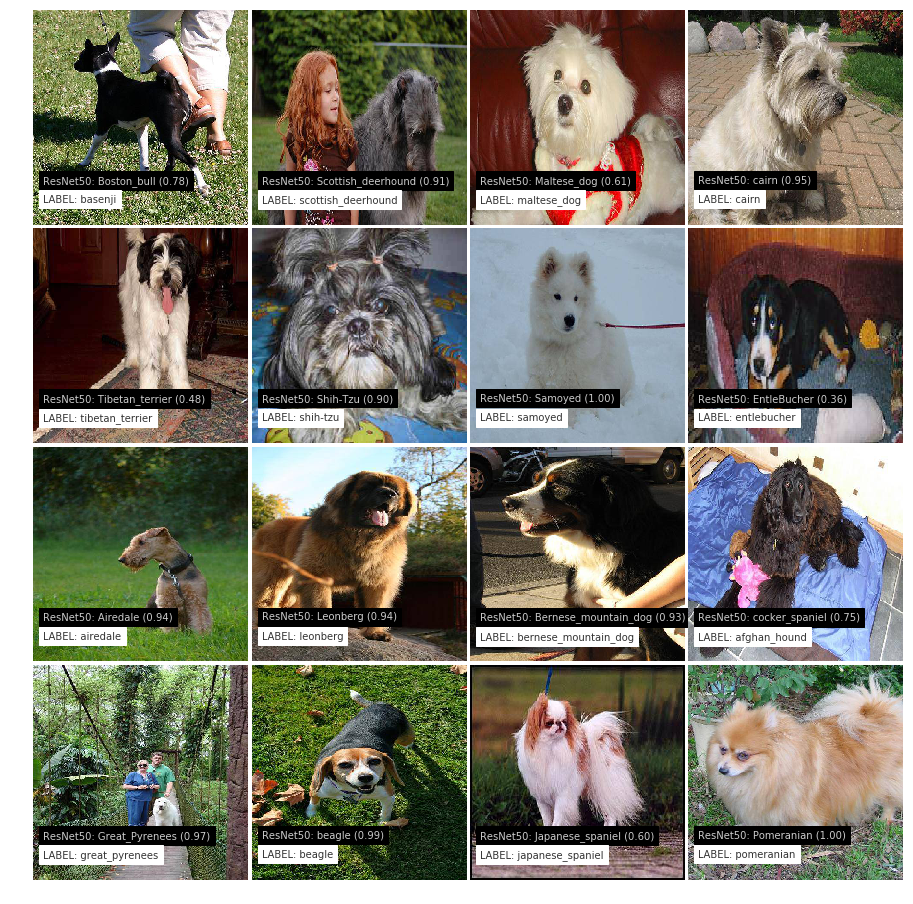

In [14]:
model = ResNet50(weights='imagenet')
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

Preprocessing and prediction seems to be working. 75% accuracy on these 16 images.

# Extract VGG16 bottleneck features

In [16]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:24, 72.41it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [18]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - 248s    
VGG train bottleneck features shape: (1409, 512) size: 721,408
VGG valid bottleneck features shape: (368, 512) size: 188,416


# LogReg on VGG bottleneck features

In [19]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [20]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.351782583841
Validation VGG Accuracy 0.91847826087


Not bad, 90% accuracy for the top 16 classes. The multiclass classification with 120 classes is more difficult so these LogLoss/Accuracy scores does not translate to LB.

# Extract Xception bottleneck features

In [23]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:24, 72.07it/s]

Train Images shape: (1777, 299, 299, 3) size: 476,596,731


In [25]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 259s    
Xception train bottleneck features shape: (1409, 2048) size: 2,885,632
Xception valid bottleneck features shape: (368, 2048) size: 753,664


# LogReg on Xception bottleneck features


In [26]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.0682786993035
Validation Xception Accuracy 0.98097826087


![](https://pics.me.me/such-wow-much-awesome-many-cool-bestest-thug-life-19337110.png)

Much better! 98% accuracy 0.07 LogLoss.

# Extract Inception bottleneck features

In [21]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - 67s    
InceptionV3 train bottleneck features shape: (1409, 2048) size: 2,885,632
InceptionV3 valid bottleneck features shape: (368, 2048) size: 753,664


# LogReg on Inception bottleneck features

In [27]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

NameError: name 'train_i_bf' is not defined

In [23]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Inception LogLoss 11.9906719215
Validation Inception Accuracy 0.146739130435


# LogReg on all bottleneck features

In [ ]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Training this model on the full dataset would give 0.3 LogLoss on LB.

# Check errors
We still have a few misclassification errors.

In [34]:
print yv[:10]
print yv.shape
print (yv[:5]*range(NUM_CLASSES)).sum(axis=1)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]]
(368, 16)
[ 12.   2.  10.  12.  12.]


[ 12.   2.  10.  12.  12.   2.   0.   6.  10.   9.  13.   4.  12.   9.   9.
   3.  10.   5.   9.   0.   1.   9.   1.   8.  11.  10.  11.  11.   1.  12.
   9.  13.   0.   5.  11.  13.   4.   4.   0.  14.   9.  12.   6.  14.   6.
   3.  12.   4.   1.  15.   3.   4.  10.  11.  11.   2.   7.  13.   0.  10.
   5.   1.  10.   5.  14.   8.   7.   2.  13.  14.   1.   7.   3.  15.   1.
   7.   3.   9.  15.   0.   6.  12.   1.  15.  15.   8.  10.   4.   1.  10.
   0.   5.   5.  13.   0.  13.  11.   1.   7.   5.  12.  10.   1.  14.   6.
   3.  12.  15.  15.   1.  10.   2.   9.   0.   9.   1.  14.   7.   6.   1.
   4.   5.  11.  15.   0.   8.  10.  14.  10.   8.   5.   3.   0.   2.  12.
   9.   3.   7.   7.  10.   4.  14.   3.   8.   9.   7.   0.   7.   1.   1.
   7.   2.  12.   0.   7.  14.   8.  12.   2.   8.   0.   0.  13.   3.  15.
   4.   8.  11.   3.   2.  14.   2.  15.   6.   2.   4.   0.   1.   3.   2.
   9.  11.   0.  15.   0.   0.   1.  11.  12.  12.   0.   7.   1.   7.   0.
   5.   7.  

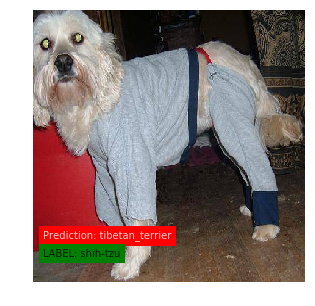

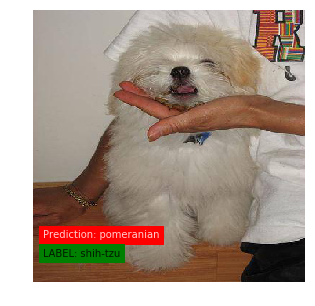

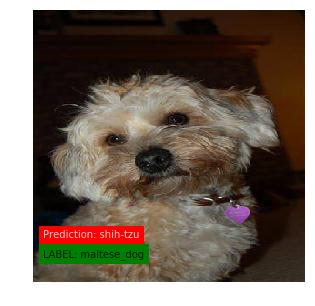

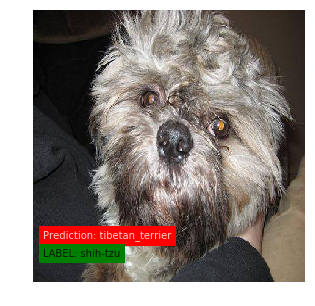

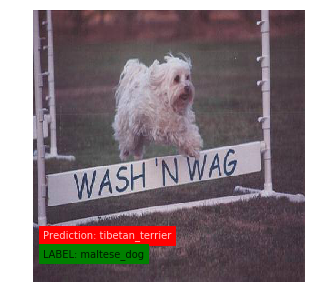

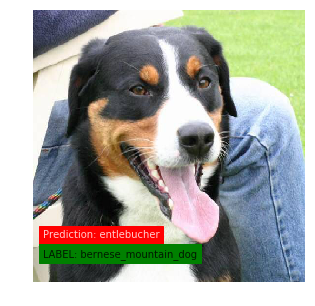

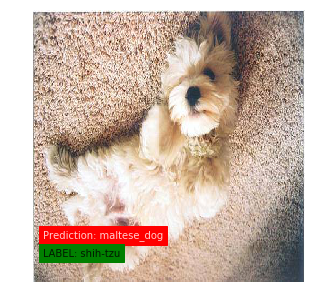

In [28]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
print valid_breeds
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()                                                    

In [ ]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')